In [15]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import warnings

from matplotlib.pyplot import subplots
from ISLP import confusion_table
from sklearn.naive_bayes import BernoulliNB 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_validate


from sklearn.tree import (DecisionTreeClassifier as DTC,
                          plot_tree, 
                          export_text)
from sklearn.metrics import (accuracy_score, log_loss)

os.chdir("C:/Users/tanja/OneDrive/Desktop/Uni/ML/Task2/congress/congressional voting")

In [5]:
train = pd.read_csv('CongressionalVotingID.shuf.lrn.csv', na_values=['unknown'], index_col="ID")
test  = pd.read_csv('CongressionalVotingID.shuf.tes.csv', na_values=['unknown'], index_col="ID")

for col in train.columns:
    train[col] = train[col].astype("category")

train.head()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
ID,,,,,,,,,,,,,,,,,
362,democrat,y,n,y,n,y,y,y,n,y,y,n,n,y,y,n,NaN
86,democrat,n,n,y,n,y,y,n,n,n,y,y,y,y,y,n,y
264,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,NaN
258,republican,n,n,n,y,y,n,n,n,n,n,n,y,n,y,NaN,y
381,democrat,y,y,y,n,n,y,NaN,y,y,n,y,n,y,n,y,y


In [6]:
# Imputation missing values 
all_feat = train.columns.drop(['class'])
x_train = train[all_feat].replace({'y': True, 'n': False})      # transform into category 

imputer = IterativeImputer(estimator=LogisticRegression(), max_iter=10, random_state=42)
x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_train_imputed = (x_train_imputed >= 0.5).astype("category")   # convert the probabilities for NA values in True or False 
warnings.filterwarnings('ignore', category=FutureWarning)

x_train_imputed.head()

C:\Users\tanja\AppData\Local\Temp\ipykernel_35344\797467448.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train = train[all_feat].replace({'y': True, 'n': False})      # transform into category
C:\Users\tanja\AppData\Local\Temp\ipykernel_35344\797467448.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  x_train = train[all_feat].replace({'y': True, 'n': False})      # transform into category
C:\Users\tanja\AppData\Local\Temp\ipykernel_35344\797467448.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed 

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
ID,,,,,,,,,,,,,,,,
362,True,False,True,False,True,True,True,False,True,True,False,False,True,True,False,True
86,False,False,True,False,True,True,False,False,False,True,True,True,True,True,False,True
264,True,False,True,False,False,False,True,True,True,False,False,False,False,False,True,True
258,False,False,False,True,True,False,False,False,False,False,False,True,False,True,False,True
381,True,True,True,False,False,True,True,True,True,False,True,False,True,False,True,True


In [7]:
train.loc[:, x_train_imputed.columns] = x_train_imputed

train.isna().sum()

class                                     0
handicapped-infants                       0
water-project-cost-sharing                0
adoption-of-the-budget-resolution         0
physician-fee-freeze                      0
el-salvador-aid                           0
religious-groups-in-schools               0
anti-satellite-test-ban                   0
aid-to-nicaraguan-contras                 0
mx-missile                                0
immigration                               0
synfuels-crporation-cutback               0
education-spending                        0
superfund-right-to-sue                    0
crime                                     0
duty-free-exports                         0
export-administration-act-south-africa    0
dtype: int64

In [8]:
# Two-way contingency table 
for col in train.columns[1:]:
    crosstab = pd.crosstab(train[col], train["class"])
    print(crosstab)
    print()

class                democrat  republican
handicapped-infants                      
False                      41          68
True                       86          23

class                       democrat  republican
water-project-cost-sharing                      
False                             67          37
True                              60          54

class                              democrat  republican
adoption-of-the-budget-resolution                      
False                                     9          80
True                                    118          11

class                 democrat  republican
physician-fee-freeze                      
False                      122           3
True                         5          88

class            democrat  republican
el-salvador-aid                      
False                 104           5
True                   23          86

class                        democrat  republican
religious-groups-in-schools      

In [9]:
# Logistic Regression
all_feat = train.columns.drop(['class'])
X = train[all_feat]  
y = train["class"] == "republican"
log_full = LogisticRegression(C=1e10, solver='liblinear', fit_intercept=True).fit(X, y)
coefs = pd.DataFrame({
    'Feature': ['intercept'] + list(X.columns),
    'Coefficient': [log_full.intercept_[0]] + list(log_full.coef_[0])
})
print(coefs)

                                   Feature  Coefficient
0                                intercept     3.139287
1                      handicapped-infants    13.394403
2               water-project-cost-sharing   -20.466584
3        adoption-of-the-budget-resolution   -23.591818
4                     physician-fee-freeze    78.985866
5                          el-salvador-aid    29.953863
6              religious-groups-in-schools   -39.341032
7                  anti-satellite-test-ban    17.734831
8                aid-to-nicaraguan-contras    -6.469110
9                               mx-missile   -21.747931
10                             immigration     0.981784
11             synfuels-crporation-cutback   -36.084802
12                      education-spending   -11.618886
13                  superfund-right-to-sue     1.790300
14                                   crime    -5.954267
15                       duty-free-exports     6.451421
16  export-administration-act-south-africa     7

In [10]:
probs_log = log_full.predict_proba(X)  
labels_log = np.where(probs_log[:, 1]>0.5, 'republican', 'democrat')
print(confusion_table(labels_log, train['class']))

Truth       democrat  republican
Predicted                       
democrat         127           1
republican         0          90


In [17]:
cv = KFold(n_splits=10, shuffle=True, random_state=0)

log_cv = cross_validate(
    estimator=log_full,
    X=X,
    y=y,
    cv=cv,
    scoring={'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}
)

print("Mean Accuracy:", np.mean(log_cv['test_accuracy']))
print("Mean F1 Score:", np.mean(log_cv['test_f1']))

Mean Accuracy: 0.9677489177489178
Mean F1 Score: 0.958837059203192


In [25]:
# Lasso Logistic Regression 
C_path = {'C': np.logspace(-4, 4, 30)}   # equi-spaced sequence on the log10 scale   
print(C_path)                            # the inverse of lambda = hyperparameter
                                         # the larger C, the smaller penalization  

lasso_log = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, fit_intercept=True)
grid_lasso = GridSearchCV(lasso_log, C_path, cv=10, scoring="accuracy", refit=True).fit(X, y)

print(grid_lasso.best_params_)  # C = 2.592943797404667

{'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04])}
{'C': np.float64(2.592943797404667)}


In [26]:
coefs_pen = pd.DataFrame({
    'Feature': ['intercept'] + list(X.columns),
    'Coefficient': [log_full.intercept_[0]] + list(log_full.coef_[0]),
    'Coefficient penalized': [grid_lasso.best_estimator_.intercept_[0]] + list(grid_lasso.best_estimator_.coef_[0])
})
print(coefs_pen)

lasso_cv = cross_validate(estimator=grid_lasso.best_estimator_, X=X, y=y, cv=cv)
np.mean(lasso_cv['test_score'])  # 0.9629870129870131 = cross validation accuracy

                                   Feature  Coefficient  Coefficient penalized
0                                intercept     3.139287               0.000000
1                      handicapped-infants    13.394403               0.530058
2               water-project-cost-sharing   -20.466584              -1.978771
3        adoption-of-the-budget-resolution   -23.591818              -2.314783
4                     physician-fee-freeze    78.985866               7.633842
5                          el-salvador-aid    29.953863               0.000000
6              religious-groups-in-schools   -39.341032              -1.044010
7                  anti-satellite-test-ban    17.734831               0.640119
8                aid-to-nicaraguan-contras    -6.469110               0.000000
9                               mx-missile   -21.747931              -2.374189
10                             immigration     0.981784               0.165825
11             synfuels-crporation-cutback   -36.084

np.float64(0.9629870129870131)

In [ ]:
# SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=0)

svm_cv = cross_validate(
    estimator=svm,
    X=X,
    y=y,
    cv=cv,
    scoring={'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}
)

print("Mean Accuracy:", np.mean(svm_cv['test_accuracy']))
print("Mean F1 Score:", np.mean(svm_cv['test_f1']))

Mean Accuracy: 0.9539112050739957
Mean F1 Score: 0.9365079365079364


In [16]:
naive = BernoulliNB().fit(X, y)
print(naive.class_log_prior_)   # log prior probabilities
print(naive.feature_log_prob_)  # empirical log probability of features given a class, P(x_i|y)

naive_cv = cross_validate(
    estimator=naive,
    X=X,
    y=y,
    cv=cv,
    scoring={'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}
)

print("Mean Accuracy:", np.mean(naive_cv['test_accuracy']))
print("Mean F1 Score:", np.mean(naive_cv['test_f1']))

[-0.54030798 -0.87363556]
[[-0.39390429 -0.74893854 -0.08068891 -3.06805294 -1.68175857 -0.85247922
  -0.22508342 -0.16846452 -0.27484493 -0.85247922 -0.70092932 -2.1517622
  -1.14624034 -1.12214279 -0.39390429 -0.03953084]
 [-1.35454566 -0.52526631 -2.04769284 -0.04396312 -0.06669137 -0.10178269
  -1.44155704 -1.96765014 -2.04769284 -0.7039581  -1.76001077 -0.15057286
  -0.12588025 -0.04396312 -2.2300144  -0.35821222]]
Mean Accuracy: 0.9169133192389006
Mean F1 Score: 0.8952427500814597


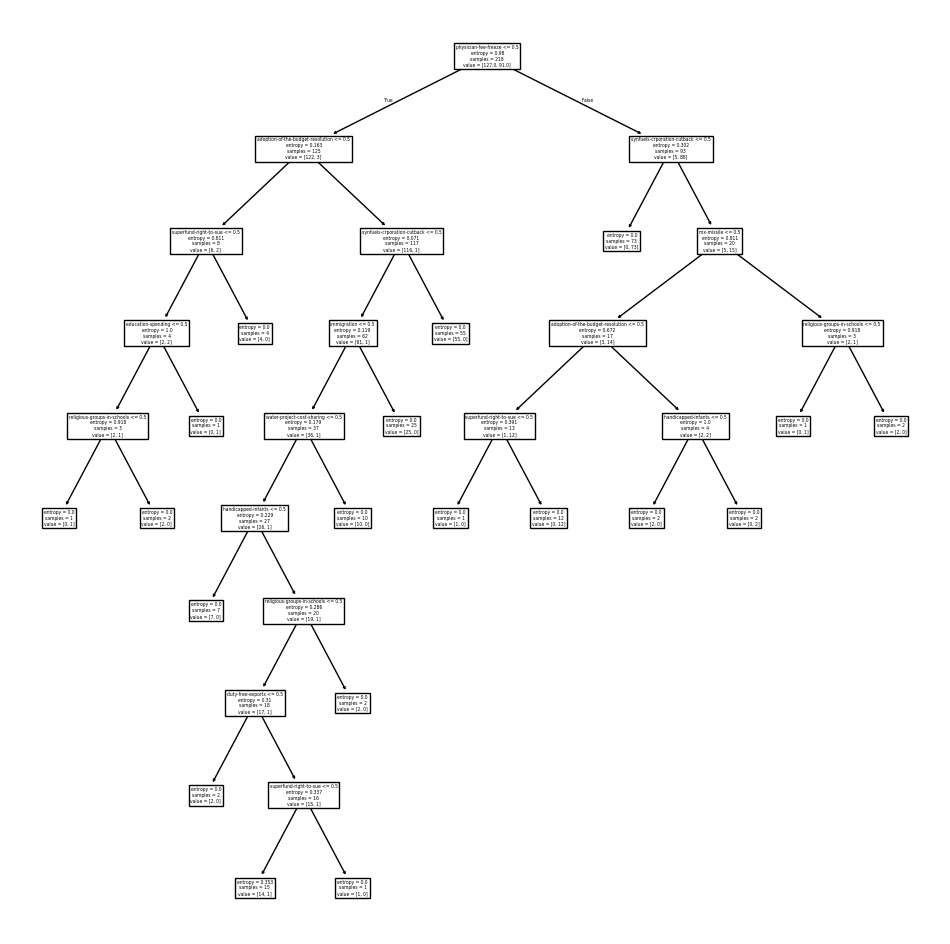

In [19]:
# Classification tree 
feature_names = list(X.columns)
tree = DTC(criterion='entropy', random_state=42).fit(X, y)


fig, ax = subplots(figsize=(12,12))
plot_tree(tree, feature_names=feature_names, ax=ax)    # to avoid overfit and the nodes are pure, we try to prune it 

# Remark: physician-fee-freeze <= 0.50 means physician-fee-freeze == False. If the statement is true, left one otherwise right one and go on...

fig.savefig("Tree.jpg", dpi=400)

{'ccp_alpha': np.float64(0.02578482176968931)}


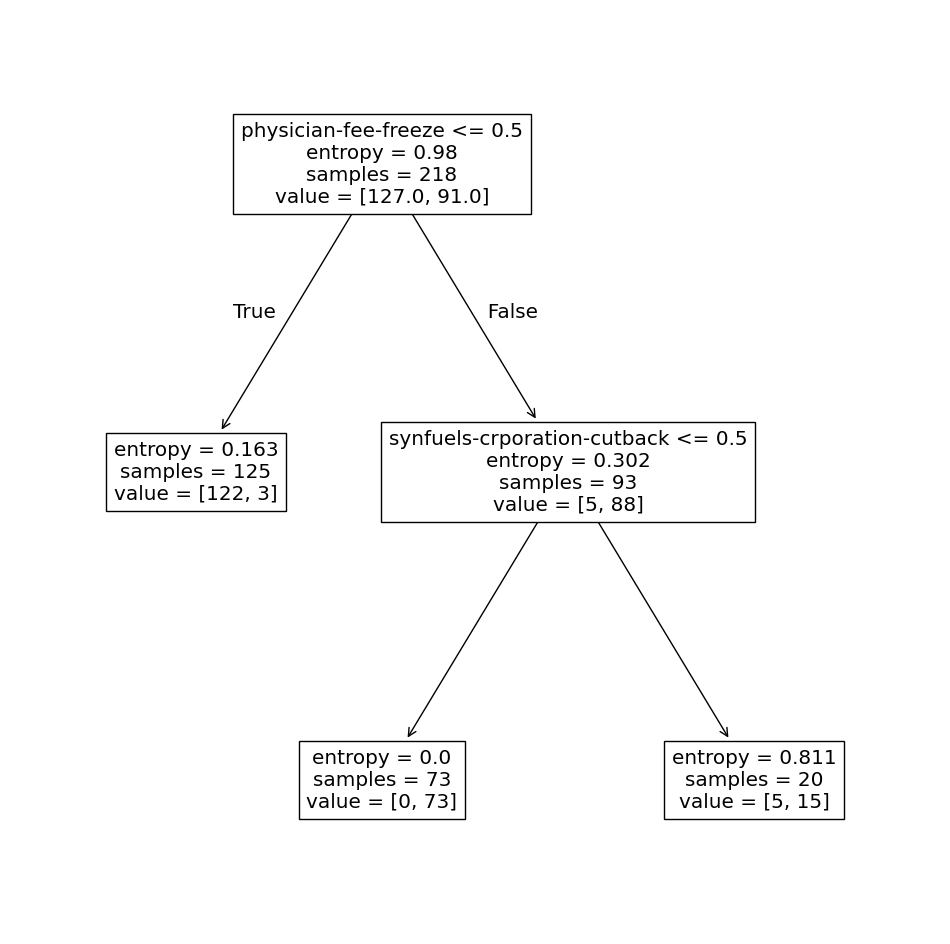

In [20]:
ccp_path = tree.cost_complexity_pruning_path(X, y)
grid_tree = GridSearchCV(tree, {'ccp_alpha': ccp_path.ccp_alphas}, 
                    refit=True, cv=cv, scoring='accuracy').fit(X, y)

print(grid_tree.best_params_ )   # alpha = 0.02578482176968931

fig, ax = subplots(figsize=(12,12))
plot_tree(grid_tree.best_estimator_, feature_names=feature_names, ax=ax)   # pruned tree

fig.savefig("Pruned_tree.jpg", dpi=400)

In [21]:
importances = pd.Series(grid_tree.best_estimator_.feature_importances_, index=feature_names)
print(importances.sort_values(ascending=False))

tree_cv = cross_validate(
    estimator=grid_tree.best_estimator_,
    X=X,
    y=y,
    cv=cv,
    scoring={'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}
)

print("Mean Accuracy:", np.mean(tree_cv['test_accuracy']))
print("Mean F1 Score:", np.mean(tree_cv['test_f1']))

physician-fee-freeze                      0.932919
synfuels-crporation-cutback               0.067081
water-project-cost-sharing                0.000000
handicapped-infants                       0.000000
el-salvador-aid                           0.000000
religious-groups-in-schools               0.000000
anti-satellite-test-ban                   0.000000
adoption-of-the-budget-resolution         0.000000
aid-to-nicaraguan-contras                 0.000000
mx-missile                                0.000000
immigration                               0.000000
education-spending                        0.000000
superfund-right-to-sue                    0.000000
crime                                     0.000000
duty-free-exports                         0.000000
export-administration-act-south-africa    0.000000
dtype: float64
Mean Accuracy: 0.9627705627705628
Mean F1 Score: 0.9479575163398695


In [31]:
# Predictions
test = test[all_feat].replace({'y': True, 'n': False})

print(test.isna().sum()) # there are some missing_values 

# Imputation from the logistic models fitted in the training set 
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns, index=test.index)
test_imputed = (test_imputed >= 0.5).astype("category")


handicapped-infants                        8
water-project-cost-sharing                20
adoption-of-the-budget-resolution          3
physician-fee-freeze                       5
el-salvador-aid                            8
religious-groups-in-schools                5
anti-satellite-test-ban                    7
aid-to-nicaraguan-contras                  3
mx-missile                                14
immigration                                4
synfuels-crporation-cutback               11
education-spending                        13
superfund-right-to-sue                     9
crime                                      6
duty-free-exports                         14
export-administration-act-south-africa    50
dtype: int64


In [32]:
y_test = grid_lasso.best_estimator_.predict(test_imputed) 
y_test = np.where(y_test == True, "republican", "democrat") 
df_test = pd.DataFrame({
    "ID": test_imputed.index,
    "class": y_test
})

df_test.columns
df_test.to_csv("Group38_submission1.csv", index=False)
# 0.95370 = test accuracy for lasso

In [33]:
y_test = grid_tree.best_estimator_.predict(test_imputed) 
y_test = np.where(y_test == True, "republican", "democrat") 
df_test = pd.DataFrame({
    "ID": test_imputed.index,
    "class": y_test
})

df_test.columns
df_test.to_csv("Group38_submission2.csv", index=False)
# 0.96296 = test accuracy for pruned tree